# Contextual Forests V2

### 1. BabelNet Iinterface

In [1]:
import requests
import json
import wikipediaapi
import time
from socket import timeout
from requests.exceptions import ConnectionError

#GLOBAL VARIABLES
wiki = wikipediaapi.Wikipedia('en')
KEY  = 'b361cac5-2b53-40a8-8df8-6a2cfb140491' #Register in BabelNet to get one f2bf42de-488b-4c87-a1c3-1c1878afc263'#'
BASE = 'https://babelnet.io/v5'
API = {
    "get_info": "getSynset",
    "get_synsets":"getSynsetIds",
    "get_relations":"getOutgoingEdges"
}

def __format_arguments(args):
    """
    Desc: Returns a formatted string for making an HTML request
    Params: - args (dict): dictionary for params values, format is {paramName:paramValue ...}
    Returns: (String) formatted string
    """
    return "&".join(["{}={}".format(key,value) for key,value in args.items()])

def __make_request(args,op,verbose=False):
    """
    Desc: Makes arequest to BabelNet API given a parametters dictionary
    Params: - args (dict): dictionary for params values, format is {paramName:paramValue ...}
            - op (string): operation, choose between {get_info,get_synsets,get_relations}
            - verbose (bool): show messages 
    Returns: (Dict) BabelNet's API response
    """
    args["key"] = KEY
    args["targetLang"] = "EN"
    r = requests.get("{}/{}?{}".format(BASE,API[op],__format_arguments(args)))
    if verbose:
        print("Status code: {}".format(r.status_code))
    return r.json() if r.ok else None

def synset_info(synset_id,verbose=False):
    """
    Desc: Returns the information associated with a BabelNet synset
    Params: - synset_id (String): BabelNet synset id
            - verbose (bool): show messages 
    Returns: (Dict) BabelNet's sysnset information
    """
    return __make_request({"id":synset_id},"get_info",verbose)

def synset_relations(synset_id,verbose=False):
    """
    Desc: Returns the outgoing semantic relations of a synset
    Params: - synset_id (String): BabelNet synset id
            - verbose (bool): show messages 
    Returns: (Dict) BabelNet's sysnset outgoing conexions
    """
    try:
        return __make_request({"id":synset_id},"get_relations",verbose)
    except (ConnectionError,timeout):
        return []

def general_categories(synset_id):
    """  
    Desc: Returns the ids of the general categories a synset belongs to
    Params: - synset_id (String): BabelNet synset id
    Returns: (List)[String] ids 
    """
    try:
        categories = [relation["target"] for relation in synset_relations(synset_id) 
                  if relation["pointer"]["shortName"] in ["is-a","part_of","subclass_of"]]
        res = []
        for cat in categories:
            try:
                #res.append(synset_info(cat)["senses"][0]["properties"]["fullLemma"])
                res.append(synset_info(cat)["senses"][0]["properties"]["synsetID"]["id"] )
            except IndexError:
                continue
        return set(res)
    except (ConnectionError,timeout):
        return []

def wiki_page(synset_id):
    """  
    Desc: Return the wikipedia page associated with a synset id
    Params: - synset_id (String): BabelNet synset id
    Returns: (Wikipediaapi.Page) wikipedia page object
    """
    try:
        synset = synset_info(synset_id)
        for sense in synset["senses"]:
            if sense['properties']["source"] == "WIKI":
                return wiki.page(sense['properties']["fullLemma"].replace("_"," "))
            else:
                continue
        return None
    except (ConnectionError,timeout):
        return None

def search_synsets(lemma,pos,searchLang="EN",verbose=False):
    """  
    Desc: Returns the ids of possible synsets associated to the provided word
    Params: - lemma (String): word for searching
            - pos (String): position (NOUN,VERB ...)
            - searchLang (String): language for search and results
            - verbose (bool): show messages 
    Returns: (List)[String]: ids 
    """
    args = {
        "lemma":lemma,
        "pos":pos,
        "searchLang":searchLang,
        "key":KEY
    }
    return [ele["id"] for ele in __make_request(args,"get_synsets",verbose)]


#search_synsets("apple","NOUN")   
#general_categories("bn:17306106n")
#wiki_page("bn:00289737n").text
#synset_info("bn:03094945n")["domains"]
        
    
                   

### Wikipedia Interface

In [2]:
import spacy
import en_core_web_lg
from nltk.stem.porter import *
from more_itertools import locate
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
import string
import numpy as np
from scipy.optimize import curve_fit
from nltk.stem import WordNetLemmatizer 

stemmer = SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer() 
nlp = en_core_web_lg.load()
STOPWORDS = "stopwords.txt" #stopwords_file
with open(STOPWORDS ) as file:
        stop_words = [x.strip() for x in file.readlines()]

wiki_freqs = {}
mx = 0
with open("wiki_freqs.txt") as f:
    for line in f.readlines():
        word,freq = line.split(" ")
        if int(freq) > mx:
            mx = int(freq)
        wiki_freqs[word] = int(freq)
    for k in wiki_freqs:
        wiki_freqs[k] = 1+wiki_freqs[k]/mx
def inv_freq(k,d):
    try:
        for key in d:
            if d[key]["pos"] == 0:
                mx = d[key]["relevance"]
        return 1/wiki_freqs[d[k]["words"].pop()] * 2*mx
    except KeyError:
        return 0

In [3]:

def average_sentence_size(text):
    """Returns the average sentence size"""
    return np.mean([len(sentence.split()) for sentence in text.split(".")])

def clean_text(text):
    """Cleans the text, punctuation marks (. , \n) will be replaced by blank spaces 
    and possessive forms ('es , 's) will be removed. 
    Any other punctuation symbol will also be removed.
    @Params:
        -text: to be cleaned
    @Returns:
        Cleaned text
    """
    text = text.replace("\n"," ").replace(","," ").replace("."," ")
    text = text.replace("'s","").replace("'es","")
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def stem_text(text,title=""):
    #pendiente hacerlo mas elegante
    """
    Uses snowball stemmer to produce a dictionary with entries:
        dic = { ...,key:(words,occurr,relevance),... }
    Where words -> list of ocurrences of key in text (page's text)
          occur -> indexes of (key) occurrences in the text
          relevance -> set to 0 (see set_relevance())
    Note that every key = (STEMMED WORD,WORD_POS (Part Of Speech))
    @Params:
        - text: text to be processed
    @Returns:
        (stem_dictionary,cleaned text length)
    """
    dic = {}
    content = clean_text(text).split() #split spaces
    count = 0
    for i,x in enumerate(nlp(clean_text(text))):
        if x.pos_ not in ["NOUN","PROPN","VERB","ADJ"]:
            continue
        try:
            int(x)
            continue
        except:
            if x.text.lower() not in stop_words and "wikipedia" not in x.text.lower() and title not in x.text.lower() :
                stemmed = stemmer.stem(x.text.lower())
                key = (stemmed,x.pos_)
                if key not in dic:
                    dic[key] = {"words":set([x.text.lower()]),"occurr":[i],"relevance":.0,"pos":0}
                else:
                    dic[key]["words"].add(x.text.lower())
                    dic[key]["occurr"].append(i)
        count += 1
    return dic,len(content),text




def relevance(word,text_len,chunk_size=100): #AQUI TENEMOS EL CUELLO DE BOTELLA
    """
    Returns word relevance (probability of being in a randomly 
    positioned block of a fixed size).
    @Params:
        - word:  entry of stem_dict
        - text_len: text size (returned by stem_text())
        - chunk_size: block size, fixed
    """
    L = 0
    v = np.array(word["occurr"])
    if len(v) < 2:
        return 1/(text_len-chunk_size)
    #occ = v[(v>chunk_size)&(v<text_len-chunk_size)]
    v = v[v<text_len]
    occ = np.diff(v)
    for i,o in enumerate(occ):
        if o > chunk_size:
            if v[i] < chunk_size:
                L += v[i]
            elif text_len - chunk_size < v[i]:
                L += text_len - v[i]
            else:
                L+= chunk_size
        else:
            L += o
    #last one
    if len(v) > 0:
        if v[-1] < chunk_size:
            L += v[-1]
        elif text_len - chunk_size < v[-1]:
            L += text_len - v[-1]
        else:
            L += chunk_size
        #print(L)
        return (L)/(text_len-chunk_size)
    else:
        return 0
       
    
def set_relevance(stem_dict,text_len,text,sort=False):
    relevances = []
    if text_len < 100: #no aceptamos artículos de menos de 300 palabras
        return None
    else:
        t1 = time()
        n_chunks = int(text_len/average_sentence_size(text)) #por ejemplo, mirar otras posibilidades dinamicas etc...
        for word in stem_dict:
            res = relevance(stem_dict[word],text_len,n_chunks)
            stem_dict[word]["relevance"] = res
        t2 = time()
    
    for k in stem_dict:
        stem_dict[k]["relevance"] *= inv_freq(k,stem_dict)**2
    
    if sort:
        
        t3 = time()
        keys = sorted(stem_dict.keys(),key=lambda k:stem_dict[k]["relevance"], reverse=True)
        for i,key in enumerate(keys):
            stem_dict[key]["pos"] = i
        t4 = time()
   # print("1"+"#"*50,t2-t1)
   # print("2"+"#"*50,t4-t3)
    return stem_dict


def fit_model(stem_dict):
    y_data = []
    if stem_dict == None: #articulo demasiado corto
        return None,None
    keys = sorted(stem_dict.keys(),key=lambda k:stem_dict[k]["relevance"], reverse=True)
    for i,key in enumerate(keys):
        stem_dict[key]["pos"] = i
        y_data.append(stem_dict[key]["relevance"])
    y_data = np.array(y_data)[y_data != 0][0] 
    x_data = np.linspace(1,len(y_data),len(y_data))
    def zipf(x,alpha): #distribucion de Zipf
        return stem_dict[keys[0]]["relevance"]/x**alpha

    popt, pcov = curve_fit(zipf,x_data,y_data)
    return lambda x: zipf(x,popt),stem_dict

def link_relevance(link,stem_dict,model):
        words = nlp(link)
        rel = []
        if ":" in link:
            return 0
        for word in words:
            try:
                pos =  stem_dict[(stemmer.stem(word.text.lower()),word.pos_)]["pos"]
                rel.append(pos)
            except KeyError:
                rel.append(len(stem_dict))
        return model(np.mean(rel))[0] if  len(rel) * sum(rel)  != 0  else 0      

def relevant_links(page,top):
    
    stem_dict = set_relevance(*stem_text(page.text,title=page.title))
    model,stem_dict = fit_model(stem_dict)
    if model is None:
        return []
    return sorted(page.links.items(),key=lambda it: link_relevance(it[0],stem_dict,model),reverse=True)[:top]


#relevant_links(wiki.page("Apple Inc."),10)

### From terms to targetted texts

In [4]:
def generalization(synset_id,top,l=[],level=1):
    if level > top:
        return 
    else:
        try:
            for child in general_categories(synset_id):
                l.append((child,level))
                generalization(child,top,l,level+1)
            return l
        except:
            return 
def concretization(page,top,max_expand,l=[],level=1):
    if level > top:
        return 
    else:
        try:
            for _,child in relevant_links(page,max_expand):
                l.append((child,level))
                concretization(child,top,max_expand,l,level+1)
            return l
        except:
            return []
    
class Concept():
    """Contains all the texts associated with a concept,
        each with an associated level of specificity"""
    def __init__(self,synset_id,pos,depth_up,depth_down):
        self.synset_id = synset_id
        self.depth_up,self.depth_down = depth_up,depth_down
        self.page = wiki_page(synset_id)
        self.pages = []
        
        if pos is "NOUN": #standard text mining
            #generalization
            for s_id,level in generalization(synset_id,depth_up):
                synset_page = wiki_page(s_id)
                if synset_page != None and synset_page.exists():
                    self.pages.append((synset_page,level))
            
            #concretization
            max_expand = int(np.ceil(np.power(len(self.pages),1/depth_down)))
            #for page,level in concretization(self.page,depth_down,max_expand):
            #self.pages += [(link[1],-1) for link in relevant_links(self.page,len(self.pages))]
            self.pages = set(self.pages)   
                
#c = Concept( "bn:00005054n ","NOUN",1,1) #apple inc.         

#print(c.pages)

### Article-Article distance

In [5]:
import sys
%matplotlib notebook
from matplotlib import pyplot as plt
page1 = wiki.page("Donald Trump")
m1,d1 = fit_model(set_relevance(*stem_text(page1.text,title=page1.title.lower())))
data = sorted([d1[k]["relevance"] for k in d1],reverse=True)
X = np.arange(len(data))
plt.plot(X,data,"b")
plt.plot(X,m1(X),"r") 
plt.show()

TypeError: 'module' object is not callable

In [ ]:
s1 = [key for key in d1 if key in d2]
print(len(s1))
s1 = sorted(s1,key=lambda k: (d1[k]["relevance"]*d2[k]["relevance"])/(1+abs(d1[k]["relevance"]-d2[k]["relevance"]
)),reverse=True)
vals = np.array([(d1[k]["relevance"]*d2[k]["relevance"])/(1+abs(d1[k]["relevance"]-d2[k]["relevance"])) for k in s1])
vals = vals[vals>0]
diff = np.abs(np.diff(vals))
#top = diff / np.array(vals[:-1])
x = np.argmax(diff<0.001*diff[0])
#x=40
X = np.array([d1[x]["pos"] for x in s1[:x+1]]) #/len(d1)
Y = np.array([d2[x]["pos"] for x in s1[:x+1]]) #/len(d2)
#print(max(c1,c2))

for l in s1[:x]:
    print(l,d1[l]["pos"],d2[l]["pos"])
v1 = np.zeros(2) 
v = np.array([np.mean(X),np.mean(Y)])
print(np.linalg.norm(v1-v))
print(x,len(vals))
#plt.scatter(X,Y)
#plt.scatter(np.mean(X),np.mean(Y),color='r')
#plt.show
plt.plot(vals)
plt.show


In [697]:
from time import time
import sys
from scipy.spatial.distance import cosine as cos_dist
from sklearn.metrics import mutual_info_score
def prob_distance(links_pos,sample):
    mu = len(sample)*np.mean(links_pos)
    sigma = np.std(links_pos)*np.sqrt(len(sample))
    x = sum(sample)
    return norm.cdf(x,loc=mu,scale=sigma) if x <= mu else np.inf


def aa_distance(d1,d2):
    if d1 is None or d2 is None:
        return np.inf
    s1 = [(k,(d1[k]["relevance"]*d2[k]["relevance"])/(1+abs(d1[k]["relevance"]-d2[k]["relevance"]))**2) 
         for k in d1 if k in d2 if k[1] in ["PROPN","NOUN"]]
    #s1 = [(k,1/(1+d1[k]["pos"]*d2[k]["pos"])) for  k in d1 if k in d2 if k[1] in ["PROPN","NOUN"]]
    #s1 = [(k,min(d1[k]["relevance"],d2[k]["relevance"])) for k in d1 if k in d2 if k[1] in ["PROPN","NOUN"]]
    #if (len(s1) < 0.01*len(d1) and len(s1) < 0.01*len(d2)):
     #   return np.inf
    
    s1,vals = zip(*sorted(s1,key=lambda it: it[1],reverse=True))
    vals = np.array(list(vals))
    vals = vals[vals > 0]
    #return d1[k]["relevance"]*d2[k]["relevance"]/(1+abs(d1[k]["relevance"]-d2[k]["relevance"]))**2
    if len(vals) < 25:
        return np.inf
    x = 25
    X,Y = zip(*[(abs(d1[y]["pos"]),abs(d2[y]["pos"])) for i,y in enumerate(s1[:x])])
    X_,Y_ = np.array(X),np.array(Y)
    print(s1[:x])
    print(len(d1))
    print(len(d2))
    print(len(vals))
    print(X_,Y_)
    bins = [0.,5,np.inf]
    #Y_ = [-x if x <= 5 else x for x in Y_]
    print(bins)
    X_ = np.digitize(X_, bins)
    Y_ = np.digitize(Y_, bins)
    X_[X_ == 2] = 0
    Y_[Y_ == 2] = 0
    print(X_,Y_)
    ones_x = np.where(X_==1)[0]
    ones_y = np.where(Y_==1)[0]
    if len(ones_y) == 0 and len(ones_x) == 0:
        return np.inf
    return np.linalg.norm([(x*(5-X[i])+y*(5-Y[i])) for i,(x,y) in enumerate(zip(X_,Y_))])
p1 = wiki.page("Crane (machine)")
p2 = wiki.page("Construction")
d1 = set_relevance(*stem_text(p1.text,title=p1.title.lower()),sort=True)
d2 = set_relevance(*stem_text(p2.text,title=p2.title.lower()),sort=True)
aa_distance(d1,d2)

(('build', 'NOUN'), ('work', 'NOUN'), ('engin', 'NOUN'), ('design', 'NOUN'), ('site', 'NOUN'), ('type', 'NOUN'), ('project', 'NOUN'), ('materi', 'NOUN'), ('structur', 'NOUN'), ('process', 'NOUN'), ('water', 'NOUN'), ('centuri', 'NOUN'), ('system', 'NOUN'), ('job', 'NOUN'), ('bridg', 'NOUN'), ('area', 'NOUN'), ('industri', 'NOUN'), ('exampl', 'NOUN'), ('machineri', 'NOUN'), ('instal', 'NOUN'), ('transport', 'NOUN'), ('case', 'NOUN'), ('requir', 'NOUN'), ('control', 'NOUN'), ('worker', 'NOUN'))
1487
876
147
[  6  19  17  40  11   5 379  65  76 228  54  46  33  97  66  67 227 195
  69 152 253  53 341  80 200] [  1   2   5   3   9  56   0  27  20   8  57  71 105  49  66  72  18  32
 109  50  28 225  36 211 102]
[0.0, 5, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


7.3484692283495345

In [638]:
#2.995732273553991
#0.0001391642949083195
###################SORTING TEST#################################
pag = wiki.page("Kiwifruit")
d = set_relevance(*stem_text(pag.text,title=pag.title.lower()),sort=True)
print(list(d.keys())[0:100])
L = []

[('shorten', 'VERB'), ('kiwi', 'VERB'), ('australia', 'PROPN'), ('zealand', 'PROPN'), ('chines', 'ADJ'), ('gooseberri', 'NOUN'), ('edibl', 'ADJ'), ('berri', 'NOUN'), ('speci', 'NOUN'), ('woodi', 'NOUN'), ('vine', 'NOUN'), ('genus', 'NOUN'), ('actinidia', 'PROPN'), ('common', 'ADJ'), ('cultivar', 'NOUN'), ('group', 'NOUN'), ('deliciosa', 'NOUN'), ('hayward', 'PROPN'), ('oval', 'ADJ'), ('size', 'NOUN'), ('larg', 'ADJ'), ('hen', 'NOUN'), ('egg', 'NOUN'), ('centimetr', 'NOUN'), ('inch', 'NOUN'), ('length', 'NOUN'), ('cm', 'NOUN'), ('diamet', 'NOUN'), ('thin', 'ADJ'), ('fuzzi', 'ADJ'), ('fibrous', 'ADJ'), ('tart', 'ADJ'), ('light', 'ADJ'), ('brown', 'ADJ'), ('skin', 'NOUN'), ('light', 'NOUN'), ('green', 'ADJ'), ('golden', 'ADJ'), ('flesh', 'NOUN'), ('row', 'NOUN'), ('tini', 'ADJ'), ('black', 'ADJ'), ('seed', 'NOUN'), ('fruit', 'NOUN'), ('soft', 'ADJ'), ('textur', 'NOUN'), ('sweet', 'ADJ'), ('uniqu', 'ADJ'), ('flavour', 'NOUN'), ('china', 'PROPN'), ('produc', 'VERB'), ('half', 'NOUN'), ('tot

In [717]:
from time import sleep
###################SORTING TEST#################################
L = []
names = ["Pointe shoes",
         "Donald Trump",
         "Apple Inc.",
         "Table (furniture)",
         "Kiwifruit",
         "Swan Lake", 
         "Barishnikov",
        "Donald L. Trump",
        "Natalia Makarova",
        "Repsol",
        "Endesa",
        "Energy",
         "Barack Obama",
         "Democratic Party (United States)",
         "Queen (band)",
         "IPhone",
         "Apple",
         "Banana",
         "Dog",
         "Spain",
         "United States",
         "Petroleum",
         "Elton John",
         "Pedro Sánchez Castejón",
         "Bad Bunny",
         "Tesla, Inc.",
         "Crane (bird)",
         "Crane (machine)",
         "Queen regnant",
         "Twitter",
         "YouTube",
         "Pemex",
         "Samsung",
         "Meghan Markle",
         "Gabriel Macht",
         "Ewan McGregor",
         "Cristiano Ronaldo",
         "Japan",
         "Fly (clothing)",
         "Fly",
         "Green (color)",
         "Musician",
         "OSX",
         "Michael Douglas",
         "Macintosh"
        ]

for name in names:
    p1 = wiki.page("Facebook")
    p2 = wiki.page(name)
    d1 = set_relevance(*stem_text(p1.text,title=p1.title.lower()),sort=True)
    d2 = set_relevance(*stem_text(p2.text,title=p2.title.lower()),sort=True)
    L.append((aa_distance(d1,d2),name))

(('platform', 'NOUN'), ('support', 'NOUN'), ('custom', 'NOUN'), ('fabric', 'NOUN'), ('time', 'NOUN'), ('work', 'NOUN'), ('point', 'NOUN'), ('type', 'NOUN'), ('exampl', 'NOUN'), ('materi', 'NOUN'), ('edg', 'NOUN'), ('period', 'NOUN'), ('result', 'NOUN'), ('area', 'NOUN'), ('process', 'NOUN'), ('feel', 'NOUN'), ('usag', 'NOUN'), ('profil', 'NOUN'), ('number', 'NOUN'), ('month', 'NOUN'), ('year', 'NOUN'), ('devic', 'NOUN'), ('featur', 'NOUN'), ('histori', 'NOUN'), ('respons', 'NOUN'))
2339
565
70
[  6 112 114 406  73 574 787 387 170 523 494 126 376 861 544 668 357  17
  22  39  42  51  59 122 140] [ 19  14  31   9  70  12   6  34 110  36  41 131 108  51 164 140 167 377
 538 507 544 416 508 540 474]
[0.0, 5, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('state', 'PROPN'), ('unit', 'PROPN'), ('year', 'NOUN'), ('compani', 'NOUN'), ('day', 'NOUN'), ('campaign', 'NOUN'), ('action', 'NOUN'), ('govern', 'NOUN'), ('polici', 'NOUN'),

(('compani', 'NOUN'), ('share', 'NOUN'), ('month', 'NOUN'), ('time', 'NOUN'), ('countri', 'NOUN'), ('firm', 'NOUN'), ('group', 'PROPN'), ('market', 'NOUN'), ('custom', 'NOUN'), ('employe', 'NOUN'), ('capit', 'NOUN'), ('power', 'NOUN'), ('oper', 'NOUN'), ('project', 'NOUN'), ('mobil', 'NOUN'), ('solut', 'NOUN'), ('interest', 'NOUN'), ('user', 'NOUN'), ('point', 'NOUN'), ('site', 'NOUN'), ('servic', 'NOUN'), ('group', 'NOUN'), ('websit', 'NOUN'), ('day', 'NOUN'), ('year', 'NOUN'))
2339
360
77
[  1  82  39  73  78 166 108 313 114  45 584 701 585 345 243 815 837   0
 787   5  11  16  26  38  42] [  1  12  52  24  45  19  58  16  65  81  13   4  26  63  84  36  39 217
  86 309 308 338 246 331 344]
[0.0, 5, inf]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] [1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('time', 'NOUN'), ('exampl', 'NOUN'), ('system', 'NOUN'), ('process', 'NOUN'), ('chang', 'NOUN'), ('work', 'NOUN'), ('organ', 'NOUN'), ('case', 'NOUN'), ('day', 'NOUN'), ('activ',

(('unit', 'PROPN'), ('state', 'PROPN'), ('countri', 'NOUN'), ('year', 'NOUN'), ('govern', 'NOUN'), ('number', 'NOUN'), ('peopl', 'NOUN'), ('group', 'NOUN'), ('american', 'PROPN'), ('elect', 'NOUN'), ('nation', 'NOUN'), ('nation', 'PROPN'), ('china', 'PROPN'), ('polici', 'NOUN'), ('network', 'NOUN'), ('develop', 'NOUN'), ('america', 'PROPN'), ('action', 'NOUN'), ('day', 'NOUN'), ('histori', 'NOUN'), ('share', 'NOUN'), ('respons', 'NOUN'), ('compani', 'NOUN'), ('time', 'NOUN'), ('secur', 'NOUN'))
2339
2627
458
[ 27  36  78  42  72  22  54  16 195  56 274  99 102  53  40 118 273  43
  38 122  82 140   1  73  69] [  1   0   2  11   8  30  13  70   4  42   7  25  31  95 132  38  14 222
 272  83 136  78 729 182 233]
[0.0, 5, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0] [1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('year', 'NOUN'), ('unit', 'PROPN'), ('countri', 'NOUN'), ('product', 'NOUN'), ('state', 'PROPN'), ('compani', 'NOUN'), ('number', 'NOUN'), ('day', 'NOUN'), ('ti

(('user', 'NOUN'), ('content', 'NOUN'), ('compani', 'NOUN'), ('site', 'NOUN'), ('servic', 'NOUN'), ('video', 'NOUN'), ('websit', 'NOUN'), ('advertis', 'NOUN'), ('platform', 'NOUN'), ('media', 'NOUN'), ('news', 'NOUN'), ('month', 'NOUN'), ('unit', 'PROPN'), ('data', 'NOUN'), ('day', 'NOUN'), ('year', 'NOUN'), ('number', 'NOUN'), ('network', 'NOUN'), ('post', 'NOUN'), ('polici', 'NOUN'), ('app', 'NOUN'), ('inform', 'NOUN'), ('featur', 'NOUN'), ('state', 'PROPN'), ('ad', 'NOUN'))
2339
2501
576
[ 0  7  1  5 11 68 26 20  6 14 12 39 27 18 38 42 22 40 15 53 10  3 59 36
 80] [  3   1  18   7   8   0  19  24  39  38  61  33  49  76  46  40  82  56
 112  37 118 195  42 108  41]
[0.0, 5, inf]
[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0] [1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('compani', 'NOUN'), ('govern', 'NOUN'), ('year', 'NOUN'), ('news', 'NOUN'), ('time', 'NOUN'), ('peopl', 'NOUN'), ('servic', 'NOUN'), ('controversi', 'NOUN'), ('share', 'NOUN'), ('campaign', 'NOUN'), ('in

(('time', 'NOUN'), ('period', 'NOUN'), ('age', 'NOUN'), ('text', 'NOUN'), ('person', 'NOUN'), ('group', 'NOUN'), ('number', 'NOUN'), ('chang', 'NOUN'), ('countri', 'NOUN'), ('link', 'NOUN'), ('record', 'NOUN'), ('exampl', 'NOUN'), ('theori', 'NOUN'), ('sourc', 'NOUN'), ('term', 'NOUN'), ('practic', 'NOUN'), ('structur', 'NOUN'), ('incom', 'NOUN'), ('split', 'NOUN'), ('languag', 'NOUN'), ('revolut', 'NOUN'), ('art', 'NOUN'), ('area', 'NOUN'), ('music', 'NOUN'), ('health', 'NOUN'))
2339
247
44
[  73  126  240  602  291   16   22   65   78  120  149  170  301  302
  529  625  646  652  762  757  829  859  861 2227  869] [  4   5  34  20  38 237 236 197 231 163 195 173 194 183 196 202 207 201
 176 218  94 232 220   0 215]
[0.0, 5, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
(('user', 'NOUN'), ('applic', 'NOUN'), ('featur', 'NOUN'), ('number', 'NOUN'), ('platform', 'NOUN'), ('compani', 'NOUN'), ('year', 'NOUN'), ('version', 'N

In [719]:
sorted(L)

[(1.0, 'Crane (bird)'),
 (1.0, 'Fly'),
 (1.0, 'Kiwifruit'),
 (2.0, 'Ewan McGregor'),
 (2.0, 'Meghan Markle'),
 (2.23606797749979, 'Gabriel Macht'),
 (3.0, 'Pedro Sánchez Castejón'),
 (3.7416573867739413, 'Dog'),
 (4.0, 'Crane (machine)'),
 (4.0, 'Green (color)'),
 (4.0, 'Swan Lake'),
 (4.47213595499958, 'Natalia Makarova'),
 (4.58257569495584, 'Queen (band)'),
 (5.0, 'Democratic Party (United States)'),
 (5.0, 'Petroleum'),
 (5.0, 'Table (furniture)'),
 (5.0990195135927845, 'Musician'),
 (5.385164807134504, 'Donald L. Trump'),
 (5.385164807134504, 'Energy'),
 (5.385164807134504, 'Michael Douglas'),
 (5.656854249492381, 'Barishnikov'),
 (5.656854249492381, 'Spain'),
 (5.744562646538029, 'Cristiano Ronaldo'),
 (5.744562646538029, 'Elton John'),
 (6.0, 'Barack Obama'),
 (6.48074069840786, 'Japan'),
 (6.48074069840786, 'Tesla, Inc.'),
 (7.14142842854285, 'Donald Trump'),
 (8.18535277187245, 'United States'),
 (8.366600265340756, 'Macintosh'),
 (9.055385138137417, 'Pemex'),
 (9.219544457292

In [641]:
for i in range()

SyntaxError: invalid syntax (<ipython-input-641-f8d1be0104ca>, line 1)

# playground

<IPython.core.display.Javascript object>


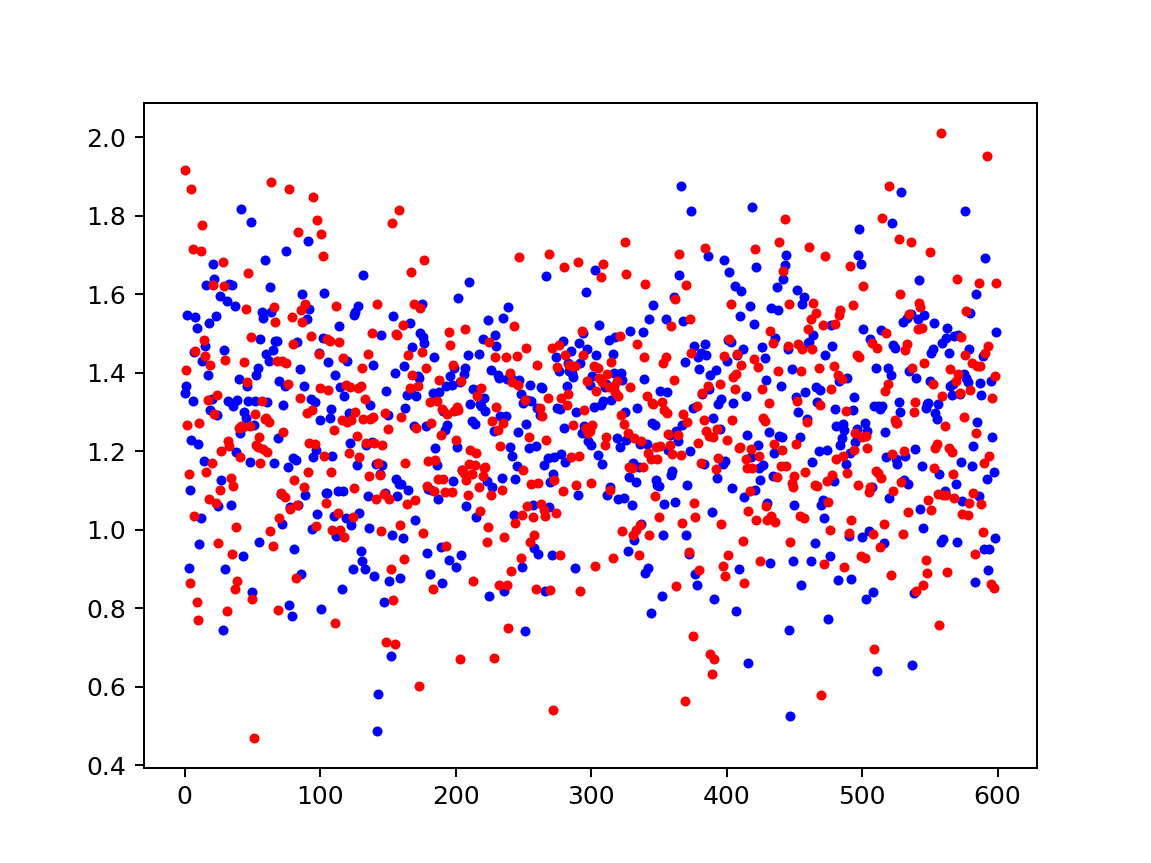

In [361]:
from sklearn.preprocessing import normalize
%matplotlib notebook
L = []
for x in range(600):
    n = 30
    rn = np.random.randint(3000,size=(n,2))
    rn = rn.astype(float)
    rn[:,0] = np.abs(rn[:,0]-np.arange(n))/3000
    rn[:,1] = np.abs(rn[:,1]-np.arange(n))/3000
    y = np.linalg.norm(rn[:,0]-rn[:,1])
    L.append(y)
    plt.plot(x,y,'b.')
    
for x in range(600):
    n = 10
    rn = np.random.randint(1500,size=(n,2))
    rn = rn.astype(float)
    rn[:,0] = np.abs(rn[:,0]-np.arange(n))/1500
    rn[:,1] = np.abs(rn[:,1]-np.arange(n))/1500
    y = np.linalg.norm(rn[:,0]-rn[:,1])
    plt.plot(x,y,'r.')

Given a sample of positive bounded non-repited integers i.e. $$X = \{x_1,x_2,...,x_n\}, \quad x_i \neq x_j, x_i \leq K \in \mathbb{N} \quad \forall i,j$$
We want to estimate the distribution of the sum statistic $$ S_n = \sum_{i=1}^n x_i $$
According to the Central Limit Theorem we've got that
$$S_n \equiv \mathcal{N}(n\mu,n\sigma) $$

"plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *\n               np.exp( - (np.array(bins) - mu)**2 / (2 * sigma**2) ),\n         linewidth=2, color='r')"

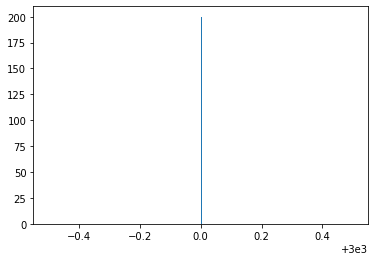

In [140]:
from random import sample
from scipy.stats import norm
from matplotlib import pyplot as plt
%matplotlib inline
L = []
K = 3000
S = 1000
poss = np.array(sample(range(3000), K))
for _ in range(3000):
    x = np.array(sample(range(30000), K))
    y = np.array(sample(range(30000), S))
    L.append(len([k for k in x if k in y]))
    #L.append(np.sum([min(a,b) for a,b in zip(x,y)]))
count, bins, ignored = plt.hist(L,bins=200,density=True)

#plt.plot(bins,norm.pdf(bins,loc=mu,scale=sigma) ,linewidth=2, color='r')
"""plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (np.array(bins) - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')"""
#plt.plot()
    
#plt.show()

In [488]:
wiki.page("Musician").text

'A musician is a person who plays a musical instrument or is musically talented. Anyone who composes, conducts, or performs music is referred to as a musician. A musician who plays a musical instrument is also known as an instrumentalist. A person who is able to play a number of instruments is called a multi-instrumentalist. A musician may perform on their own (a soloist) or as part of a group, band or orchestra.\nMusicians can specialize in any musical style, and some musicians play in a variety of different styles depending on cultures and background. Examples of a musician\'s possible skills include performing, conducting, singing, rapping, producing, composing, arranging, and the orchestration of music.\n\nMusicians by era\nMedieval\nIn the Middle Ages, instrumental musicians performed with soft ensembles inside and loud instruments outdoors. Many European musicians of this time catered to the Roman Catholic Church, and they provided arrangements structured around Gregorian chant s

#### 